In [59]:
import pandas as pd
import pickle as pkl
import shap
from sklearn.metrics import mean_squared_error

In [60]:
rf_results = pd.read_csv('../_data/full_data_with_predictions_rf.csv')
gbm_results = pd.read_csv('../_data/full_data_with_predictions_gbm.csv')
xgb_results = pd.read_csv('../_data/full_data_with_predictions_xgboost.csv')

In [61]:
print(f'RMSE for Random Forest: {mean_squared_error(rf_results.percent_vaccinated_log, rf_results.prediction, squared=True)}')
print(f'RMSE for GBM: {mean_squared_error(gbm_results.percent_vaccinated_log, gbm_results.prediction, squared=True)}')
print(f'RMSE for XGBoost: {mean_squared_error(xgb_results.percent_vaccinated_log, xgb_results.prediction, squared=True)}')

RMSE for Random Forest: 0.020319031287268204
RMSE for GBM: 0.019785638295877563
RMSE for XGBoost: 0.02269971004929003


In [66]:
# Analyze results only for the best model
with open('../_data/model_gbm.pkl', 'rb') as f:
    gbm_model = pkl.load(f)

Trying to unpickle estimator DecisionTreeRegressor from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator DummyRegressor from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GradientBoostingRegressor from version 1.4.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [ ]:
# Add information about the type of municipality to the data frame (1 = urban, 2 = rural, 3 = mixed urban-rural)
def muncipality_type_conditional(x):
    if x == '1':
        return 'urban'
    elif x == '2':
        return 'rural'
    else:
        return 'mixed_urban_rural'

gbm_results['municipality_type'] = gbm_results['municipality_code'].map(lambda x: muncipality_type_conditional(str(x)[-1]))

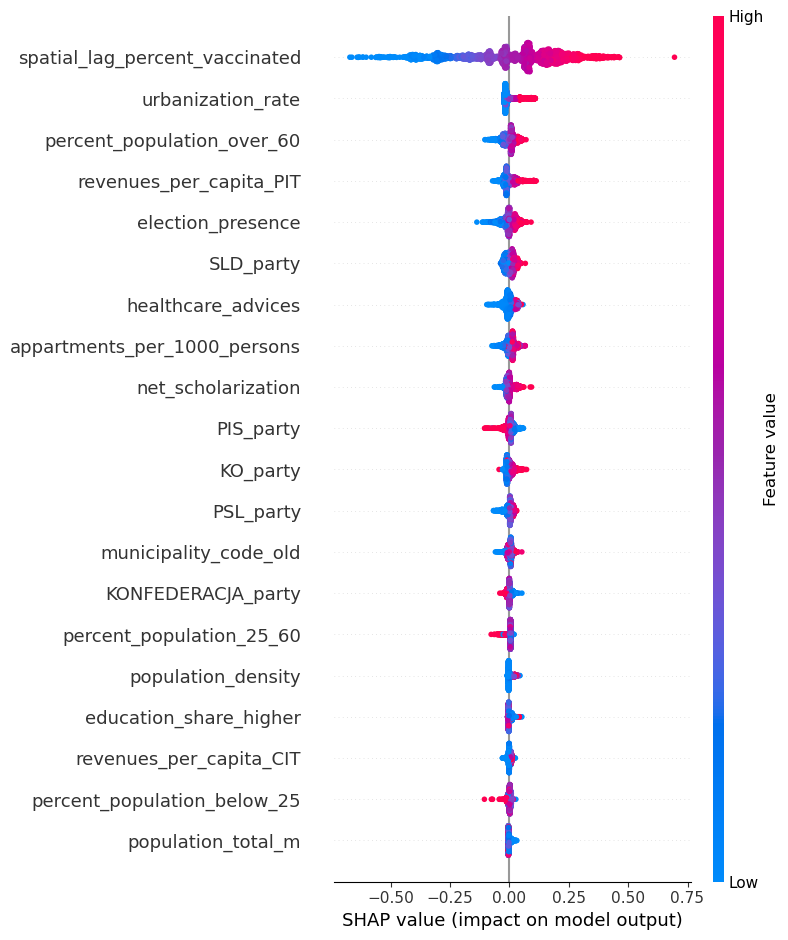

In [125]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gbm_model)

filtered_df = gbm_results.drop(columns=['percent_vaccinated_log', 'prediction'])
shap_values = explainer.shap_values(filtered_df)

shap.summary_plot(shap_values, filtered_df)

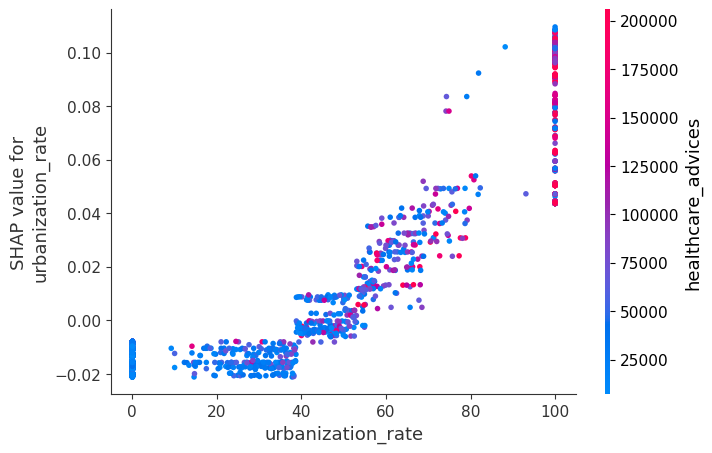

In [127]:
shap.dependence_plot("urbanization_rate", shap_values, filtered_df, interaction_index="healthcare_advices")

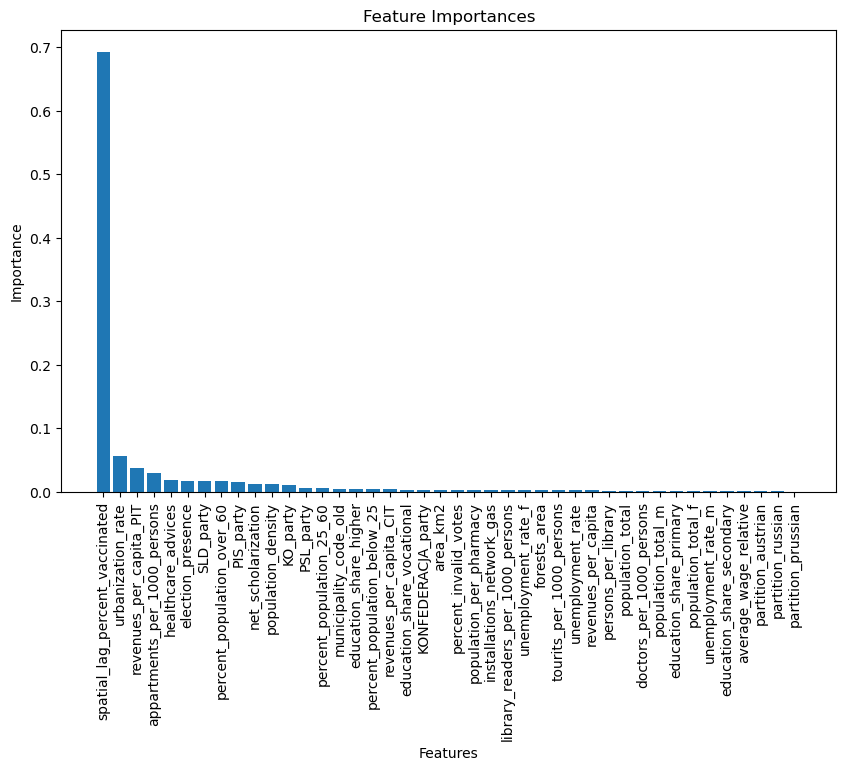

In [121]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = gbm_model.feature_importances_

# Get the names of the features
feature_names = gbm_model.feature_names_in_  # Assuming X_train is a DataFrame

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by feature importances
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a barplot
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

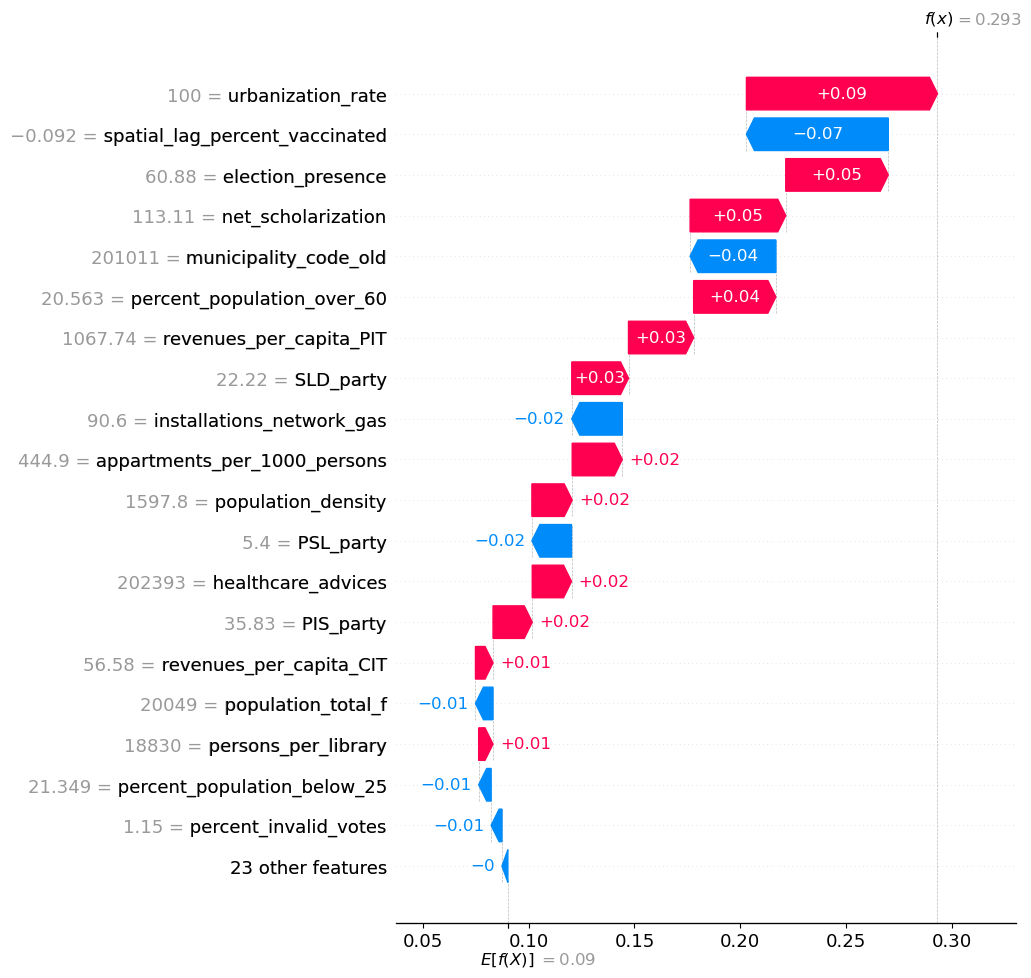

In [114]:
explainer = shap.Explainer(gbm_model, filtered_df)
shap_values = explainer(filtered_df, check_additivity=False)
shap.plots.waterfall(shap_values[0], max_display=20)